# HomeWork 5 for GEOG 210A F25

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from scipy.io import loadmat
import requests
from scipy.io import loadmat
from io import BytesIO

pd.options.display.float_format = '{:.2e}'.format

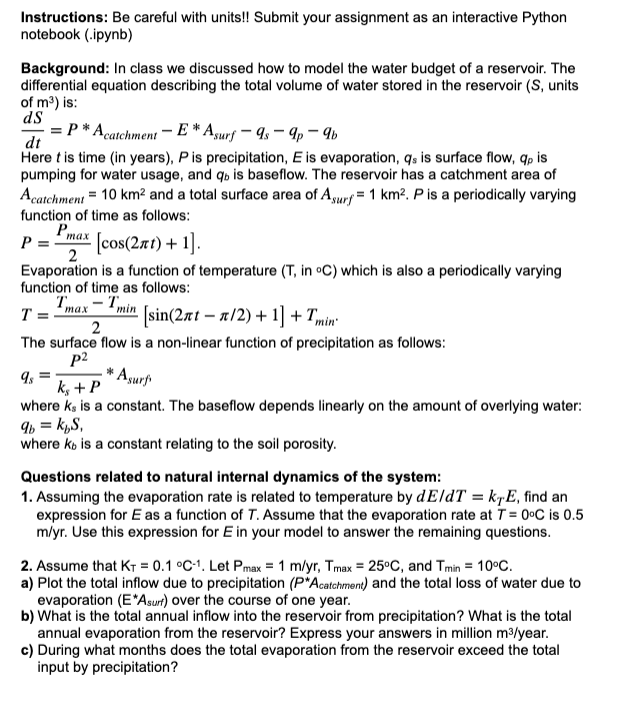

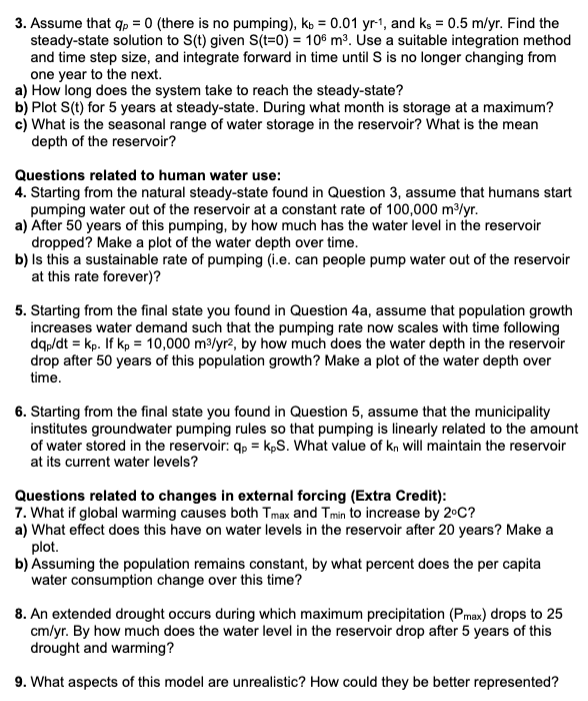

## Question 1: 
<font color="orange">
Assuming the evaporation rate is related to temperature by  dE/dT = k_T E,  find an expression for E as a function of T. Assume that the evaporation rate at T = 0°C is 0.5 m/yr. Use this expression for E in your model to answer the remaining questions.
</font>

In [2]:
# given
kT = 0.1        # assume k_T = 0.1 °C⁻¹, given by question 2 
E0 = 0.5        # m/yr at T=0°C

# Evaporation rate as a function of temperature
def E(T_vals):
    return E0 * np.exp(kT * T_vals) # T_vals function is also a periodically varying function of time, and will be defined as below

## Question 2: 
<font color="orange">
Assume that k_T = 0.1 °C⁻¹. Let P_max = 1 m/yr, T_max = 25°C, and T_min = 10°C.  

a).Plot the total inflow due to precipitation (P * A_catchment) and the total loss of water due to evaporation (E * A_surf) over the course of one year.
</font>

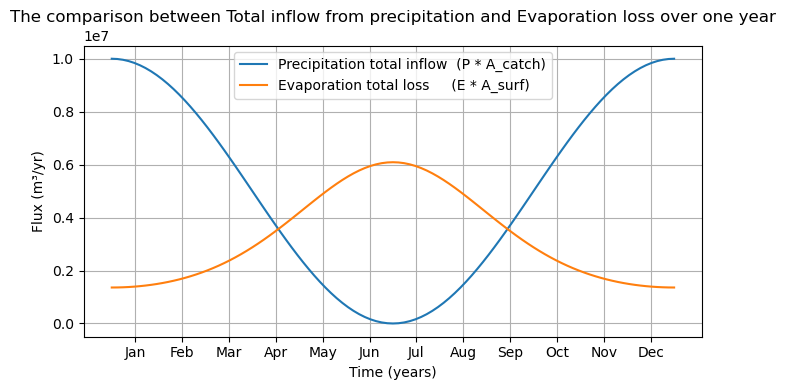

In [3]:
# define the input paramter
kT = 0.1          # per degree C
E0 = 0.5          # m/yr at T = 0°C
P_max = 1.0       # m/yr
T_max = 25.0      # °C
T_min = 10.0      # °C
A_catch = 10e6    # 10 km² -> m²
A_surf = 1e6      # 1 km²  -> m²

# define the function
def P(t):
    return P_max / 2 * (np.cos(2 * np.pi * t) + 1)
def T(t):
    return (T_max - T_min) / 2 * (np.sin(2 * np.pi * t - np.pi/2) + 1) + T_min
def E(T):
    return E0 * np.exp(kT * T)

# calculate the whole year
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_positions = np.arange(1/24, 1, 1/12)
dt = .01
t = np.arange(0,1+dt,dt)
P_vals = P(t)                    # m/yr
T_vals = T(t)                    # °C
E_vals = E(T_vals)               # m/yr

# transfter into volumn：m³/yr
P_in  = P_vals * A_catch         # P * A_catchment
E_out = E_vals * A_surf          # E * A_surf

# figure
plt.figure(figsize=(7, 4))
plt.plot(t, P_in,  label="Precipitation total inflow  (P * A_catch)")
plt.plot(t, E_out, label="Evaporation total loss     (E * A_surf)")
plt.xlabel("Time (years)")
plt.ylabel("Flux (m³/yr)")
plt.xticks(month_positions, month_labels)
plt.title("The comparison between Total inflow from precipitation and Evaporation loss over one year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


 <font color="orange">b).What is the total annual inflow into the reservoir from precipitation? What is the total annual evaporation from the reservoir? Express your answers in million m³/year.</font>


In [4]:
dt = t[1] - t[0]

total_P = np.sum(P_in) * dt
total_E = np.sum(E_out) * dt

print("Total annual precipitation inflow (million m3/yr):", total_P/1e6)
print("Total annual evaporation (million m3/yr):", total_E/1e6)

Total annual precipitation inflow (million m3/yr): 5.1
Total annual evaporation (million m3/yr): 3.3099624164869716


 <font color="orange">c)During what months does the total evaporation from the reservoir exceed the total input by precipitation?</font>

From the figure a), we can easily find from <font color='red'>April</font> to <font color='red'>September</font>, the evaporation is higher than precipiation.

## Question 3: 
<font color="orange">
Assume that q_p = 0 (there is no pumping), k_b = 0.01 yr⁻¹, and k_s = 0.5 m/yr. Find the steady-state solution to S(t) given S(t=0) = 10⁶ m³. Use a suitable integration method and time step size, and integrate forward in time until S is no longer changing from one year to the next.

a).How long does the system take to reach the steady-state?
</font>

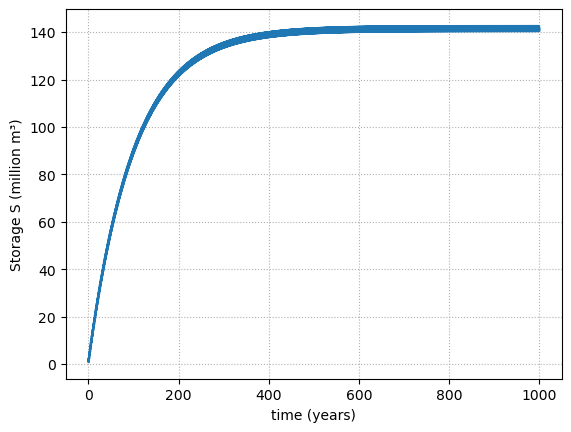

In [5]:
kb = 0.01         
ks = 0.5         
S0 = 1e6  
qp = 0       

def q_s(Pval):
    return (Pval**2 * A_surf) / (ks + Pval)

def q_b(S):
    return kb * S

def dSdt(t, S):
    P_vals = P(t)
    T_vals = T(t)
    E_vals = E(T_vals)
    return P_vals * A_catch - E_vals * A_surf - q_s(P_vals) - qp - q_b(S)

# define time domain (one year) and time step
dt = 0.01
tmax = 1000
t = np.arange(0,tmax+dt,dt)

S = 0*t
S[0] = S0

# integrate with midpoint method
for i in range(len(t)-1):
  S2 = S[i] + (dt/2) * dSdt(t[i], S[i]) # Euler forward half step
  S[i+1] = S[i] + dt * dSdt(t[i] + dt/2, S2) # Euler forward full step, evaluating DE at midpoint
  
# plot
fig2, ax = plt.subplots()
ax.plot(t,S/1e6)
ax.set_xlabel('time (years)')
ax.set_ylabel('Storage S (million m³)')
ax.grid(True, which='both',linestyle=':') # grid
plt.show()

from above figure, we can find it will up to a steady state after <font color='red'>600</font> years

<font color="orange">b).Plot S(t) for 5 years at steady-state. During what month is storage at a maximum?</font>

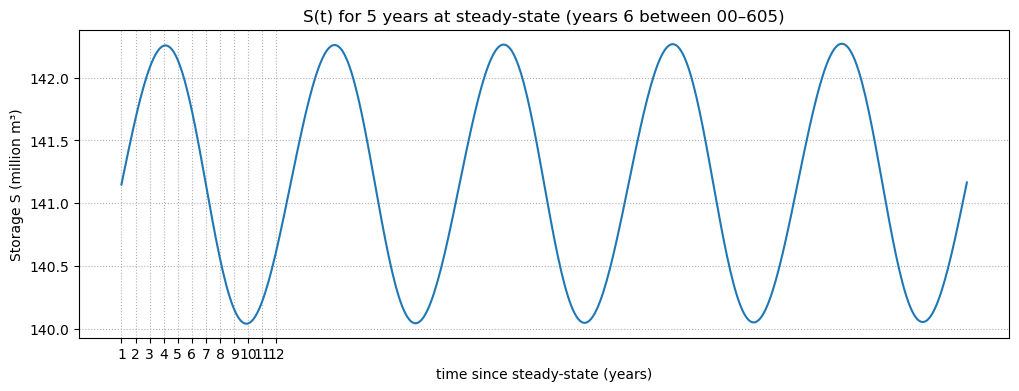

In [6]:
tmin = 600
tmax_5 = 605
mask = (t >= tmin) & (t <= tmax_5)

t5 = t[mask] - tmin  
S5 = S[mask]

# month labels
month_labels = ['1','2','3','4','5','6',
                '7','8','9','10','11','12']
month_positions = np.arange(0, 1, 1/12)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t5, S5/1e6)
ax.set_xlabel("time since steady-state (years)")
ax.set_ylabel("Storage S (million m³)")
plt.xticks(month_positions, month_labels)
ax.set_title("S(t) for 5 years at steady-state (years 6 between 00–605)")
ax.grid(True, which='both', linestyle=':')
plt.show()

from the above figure, we can find the <font color='red'>April</font> is storage at a maximum.

<font color="orange">c).What is the seasonal range of water storage in the reservoir? What is the mean depth of the reservoir?</font>

In [7]:
# ---- extract steady-state first year ----
tmin = 600
tmax_1 = 601
mask = (t >= tmin) & (t <= tmax_1)
t5 = t[mask] - tmin  
S_one = S[mask]

S_max = S_one.max()
S_min = S_one.min()
seasonal_range = S_max - S_min
S_mean = S_one.mean()

print("Seasonal range (million m³):", seasonal_range/1e6)
print("Mean Depth of the reservoir (million m³):", S_mean/1e6)

Seasonal range (million m³): 2.214883503569156
Mean Depth of the reservoir (million m³): 141.1488809324472


## Question 4: 
<font color="orange">
Starting from the natural steady-state found in Question 3, assume that humans start pumping water out of the reservoir at a constant rate of 100,000 m³/yr.

a).After 50 years of this pumping, by how much has the water level in the reservoir dropped? Make a plot of the water depth over time.
</font>

Water level drop after 50 years (m): 3.7976647270377555


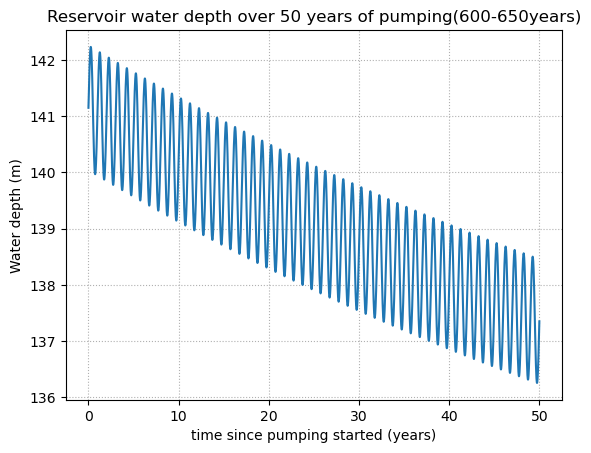

In [8]:
S0 = S_one[0]
qp = 100000      

def dSdt(t, S):
    P_vals = P(t)
    T_vals = T(t)
    E_vals = E(T_vals)
    return P_vals * A_catch - E_vals * A_surf - q_s(P_vals) - qp - q_b(S)

# define time domain (one year) and time step
dt = 0.01
tmax_pump = 50
t_pump = np.arange(0,tmax_pump+dt,dt)

S_pump_50 = 0*t_pump
S_pump_50[0] = S0

# integrate with midpoint method
for i in range(len(t_pump)-1):
    S_mid = S_pump_50[i] + (dt/2) * dSdt(t_pump[i], S_pump_50[i])
    S_pump_50[i+1] = S_pump_50[i] + dt * dSdt(t_pump[i] + dt/2, S_mid)

depth0  = S0 / A_surf
depth50 = S_pump_50[-1] / A_surf
depth_drop = depth0 - depth50
print("Water level drop after 50 years (m):", depth_drop)

depth_series = S_pump_50 / A_surf

# plot
fig, ax = plt.subplots()
ax.plot(t_pump, depth_series)
ax.set_xlabel("time since pumping started (years)")
ax.set_ylabel("Water depth (m)")
ax.set_title("Reservoir water depth over 50 years of pumping(600-650years)")
ax.grid(True, linestyle=":")
plt.show()

<font color="orange">b).Is this a sustainable rate of pumping (i.e. can people pump water out of the reservoir at this rate forever)?</font>

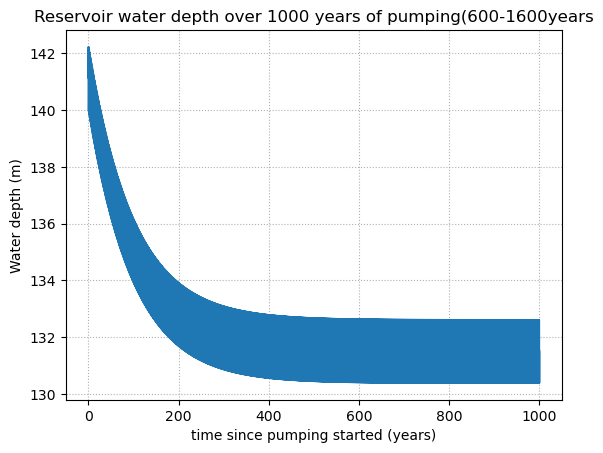

In [9]:
S0 = S_one[0]
qp = 100000      

def dSdt(t, S):
    P_vals = P(t)
    T_vals = T(t)
    E_vals = E(T_vals)
    return P_vals * A_catch - E_vals * A_surf - q_s(P_vals) - qp - q_b(S)

# define time domain (one year) and time step
dt = 0.01
tmax_pump = 1000
t_pump = np.arange(0,tmax_pump+dt,dt)

S_pump_4b = 0*t_pump
S_pump_4b[0] = S0

# integrate with midpoint method
for i in range(len(t_pump)-1):
    S_mid = S_pump_4b[i] + (dt/2) * dSdt(t_pump[i], S_pump_4b[i])
    S_pump_4b[i+1] = S_pump_4b[i] + dt * dSdt(t_pump[i] + dt/2, S_mid)

depth0  = S0 / A_surf
depth_end = S_pump_4b[-1] / A_surf
depth_drop = depth0 - depth_end
depth_series = S_pump_4b / A_surf

# plot
fig, ax = plt.subplots()
ax.plot(t_pump, depth_series)
ax.set_xlabel("time since pumping started (years)")
ax.set_ylabel("Water depth (m)")
ax.set_title("Reservoir water depth over 1000 years of pumping(600-1600years")
ax.grid(True, linestyle=":")
plt.show()

From the figure above, we see that after about 600 years of pumping, the reservoir reaches a new stable steady state. This means that, people pump water out of the reservoir at this rate forever.

## Question 5: 
<font color="orange">
Starting from the final state you found in Question 4a, assume that population growth increases water demand such that the pumping rate now scales with time following  dq_p/dt = k_p.  If k_p = 10,000 m³/yr², by how much does the water depth in the reservoir drop after 50 years of this population growth? Make a plot of the water depth over time.
</font>

Water level drop after 50 years (m): 12.956466115988988


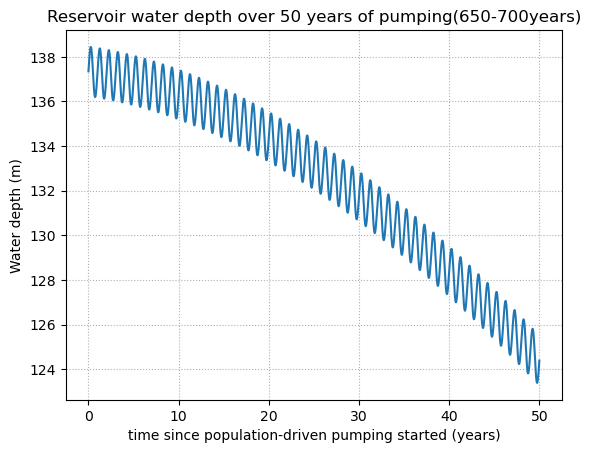

In [10]:
# initial condition from Q4a
S0_4a_final = S_pump_50[-1]
S0 = S0_4a_final     # final storage from Question 4a       
qp0 = 100000         # initial pumping rate at t=0 (m³/yr)
kp = 10000           # growth rate of pumping (m³/yr²)

# pumping rate increases linearly with time:
# q_p(t) = qp0 + kp * t
def q_p(t):
    return qp0 + kp * t

# define dS/dt under time-growing pumping
def dSdt(t, S):
    P_vals = P(t)
    T_vals = T(t)
    E_vals = E(T_vals)
    return P_vals * A_catch - E_vals * A_surf - q_s(P_vals) - q_p(t)  - q_b(S)

# integrate for 50 years
dt = 0.01
tmax_pump = 50
t_pump = np.arange(0, tmax_pump+dt, dt)

S_pump_update = 0*t_pump
S_pump_update[0] = S0

# midpoint method integration
for i in range(len(t_pump)-1):
    S_mid = S_pump_update[i] + (dt/2) * dSdt(t_pump[i], S_pump_update[i])
    S_pump_update[i+1] = S_pump_update[i] + dt * dSdt(t_pump[i] + dt/2, S_mid)

# compute water depth drop
depth0  = S0 / A_surf
depth50 = S_pump_update[-1] / A_surf
depth_drop = depth0 - depth50

print("Water level drop after 50 years (m):", depth_drop)

depth_series = S_pump_update / A_surf

# plot depth(t)
fig, ax = plt.subplots()
ax.plot(t_pump, depth_series)
ax.set_xlabel("time since population-driven pumping started (years)")
ax.set_ylabel("Water depth (m)")
ax.set_title("Reservoir water depth over 50 years of pumping(650-700years)")
ax.grid(True, linestyle=":")
plt.show()

## Question 6: 
<font color="orange">
Starting from the final state you found in Question 5, assume that the municipality institutes groundwater pumping rules so that pumping is linearly related to the amount of water stored in the reservoir: q_p = k_n S. What value of k_n will maintain the reservoir at its current water levels?
</font>

Step 1： We start from the full reservoir water‐balance equation:
because $q_{\text{b}} = k_{\text{b}}*S$ and $q_{\text{p}} = k_{\text{n}}*S$, 

thus,
$$\frac{dS}{dt} = P A_{\text{catch}} - E A_{\text{surf}} - q_s(P) - (k_b + k_n) S\$$

Step 2: Define the net inflow term:
$$F(t) = P A_{\text{catch}} - E A_{\text{surf}} - q_s(P)$$

Step3: So the governing equation becomes:
$$\frac{dS}{dt} = F(t) - (k_b + k_n)*S\$$

Step4: Since we want the reservoir to remain at its current storage level in the long term, the long-term average rate of change in storage must be zero:
$$\frac{dS}{dt} = 0\$$

Step5: Applying this steady-state condition:
$$0 = F(t) - (k_b + k_n)*S_{\text{current}}$$

Step6: Solving for the pumping proportionality constant \(k_n\):
$$k_n = F(t) / S_{\text{current}} - k_b$$

In [11]:
S_cur = S_pump_update[-1]   # m³
kb = 0.01  

dt = 0.01
t = np.arange(0, 1 + dt, dt)   

P_vals = P(t)
T_vals = T(t)
E_vals = E(T_vals)
# F(t) = P*A_catch - E*A_surf - q_s(P)
F_vals = P_vals * A_catch - E_vals * A_surf - q_s(P_vals)

# total netinput = sum(F)*dt
Ft = np.sum(F_vals) * dt     # m³/yr * yr = m³
k_n = Ft / S_cur - kb
print("k_n that maintains current level (1/yr):", k_n)             

k_n that maintains current level (1/yr): 0.0020157478560214655
